# Tutorial: Linear Regression

Agenda:
1. Spyder interface
2. Linear regression running example: boston data
3. Vectorize cost function
4. Closed form solution
5. Gradient descent

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston
boston_data = load_boston()
print(boston_data['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [3]:
# take the boston data
data = boston_data['data']
# we will only work with two of the features: INDUS (non-retail business acres per town) and RM(average #rooms per dwelling)
x_input = data[:, [2,5]]
y_target = boston_data['target']

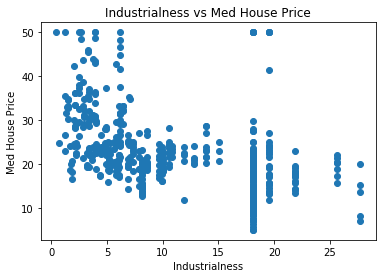

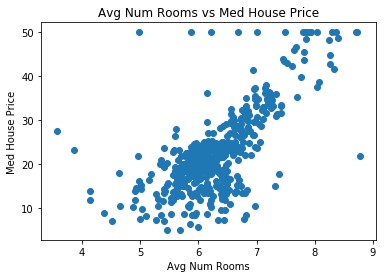

In [4]:
# Individual plots for the two features:
plt.title('Industrialness vs Med House Price')
plt.scatter(x_input[:, 0], y_target)
plt.xlabel('Industrialness')
plt.ylabel('Med House Price')
plt.show()

plt.title('Avg Num Rooms vs Med House Price')
plt.scatter(x_input[:, 1], y_target)
plt.xlabel('Avg Num Rooms')
plt.ylabel('Med House Price')
plt.show()

## Define cost function

$$\mathcal{E}(y, t) = \frac{1}{2N} \sum_{i=1}^N (y^{(i)}-t^{(i)})^2 $$

$$\mathcal{E}(y, t) = \frac{1}{2N} \sum_{i=1}^N (w_1 x_1^{(i)} + w_2 x_2^{(i)} + b -t^{(i)})^2 $$

In [15]:
def cost(w1, w2, b, X, t):
    '''
    Evaluate the cost function in a non-vectorized manner for 
    inputs `X` and targets `t`, at weights `w1`, `w2` and `b`.
    '''
    costs = 0
    for i in range(len(t)):
        y_i = w1 * X[i, 0] + w2 * X[i, 1] + b
        t_i = t[i]
        costs += 0.5 * (y_i - t_i) ** 2
    return costs / len(t)

In [16]:
cost(3, 5, 20, x_input, y_target)

2241.1239166749006

In [17]:
cost(3, 5, 0, x_input, y_target)

1195.1098850543478

## Vectorizing the cost function:

$$\mathcal{E}(y, t) = \frac{1}{2N} \| \bf{X} \bf{w} + b \bf{1} - \bf{t} \| ^2$$ 

In [18]:
def cost_vectorized(w1, w2, b, X, t):
    '''
    Evaluate the cost function in a vectorized manner for 
    inputs `X` and targets `t`, at weights `w1`, `w2` and `b`.
    '''
    N = len(y_target)
    w = np.array([w1, w2])
    y = np.dot(X, w) + b * np.ones(N)
    return np.sum((y - t)**2) / (2.0 * N)

In [19]:
cost_vectorized(3, 5, 20, x_input, y_target)

2241.1239166749015

In [20]:
cost(3, 5, 0, x_input, y_target)

1195.1098850543478

## Comparing speed of the vectorized vs unvectorized code

We'll see below that the vectorized code already
runs ~2x faster than the non-vectorized code! 

Hopefully this will convince you to always vectorized your code whenever possible

In [17]:
import time

t0 = time.time()
print cost(4, 5, 20, x_input, y_target)
t1 = time.time()
print t1 - t0

3182.40634167
0.00145196914673


In [18]:
t0 = time.time()
print cost_vectorized(4, 5, 20, x_input, y_target)
t1 = time.time()
print t1 - t0

3182.40634167
0.00056004524231


## Plotting cost in weight space

We'll plot the cost for two of our weights, assuming that bias = -22.89831573.

We'll see where that number comes from later.

Notice the shape of the contours are ovals.

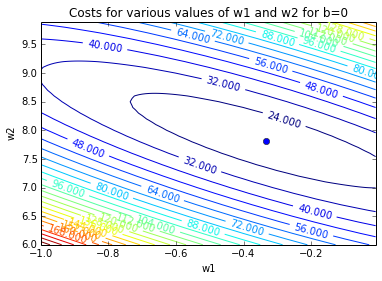

In [15]:
w1s = np.arange(-1.0, 0.0, 0.01)
w2s = np.arange(6.0, 10.0, 0.1)
z_cost = []
for w2 in w2s:
    z_cost.append([cost_vectorized(w1, w2, -22.89831573, x_input, y_target) for w1 in w1s])
z_cost = np.array(z_cost)
np.shape(z_cost)
W1, W2 = np.meshgrid(w1s, w2s)
CS = plt.contour(W1, W2, z_cost, 25)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Costs for various values of w1 and w2 for b=0')
plt.xlabel("w1")
plt.ylabel("w2")
plt.plot([-0.33471389], [7.82205511], 'o') # this will be the minima that we'll find later
plt.show()

# Exact Solution

Work this out on the board:

1. ignore biases (add an extra feature & weight instead)
2. get equations from partial derivative
3. vectorize
4. write code.

In [21]:
# add an extra feature (column in the input) that are just all ones
x_in = np.concatenate([x_input, np.ones([np.shape(x_input)[0], 1])], axis=1)
x_in

array([[  2.31 ,   6.575,   1.   ],
       [  7.07 ,   6.421,   1.   ],
       [  7.07 ,   7.185,   1.   ],
       ..., 
       [ 11.93 ,   6.976,   1.   ],
       [ 11.93 ,   6.794,   1.   ],
       [ 11.93 ,   6.03 ,   1.   ]])

In [17]:
def solve_exactly(X, t):
    '''
    Solve linear regression exactly. (fully vectorized)
    
    Given `X` - NxD matrix of inputs
          `t` - target outputs
    Returns the optimal weights as a D-dimensional vector
    '''
    N, D = np.shape(X)
    A = np.matmul(X.T, X) # why use matmul here and dot for computing c
    c = np.dot(X.T, t)
    return np.matmul(np.linalg.inv(A), c)

In [18]:
solve_exactly(x_in, y_target)

array([ -0.33471389,   7.82205511, -22.89831573])

In [19]:
# In real life we don't want to code it directly
np.linalg.lstsq(x_in, y_target)

(array([ -0.33471389,   7.82205511, -22.89831573]),
 array([ 19807.614505]),
 3,
 array([ 318.75354429,   75.21961717,    2.10127199]))

## Implement Gradient Function
$$ \frac{\partial \mathcal{E}}{\partial w_j} = \frac{1}{N}\sum_i x_j^{(i)}(y^{(i)}-t^{(i)}) $$

In [20]:
# Vectorized gradient function
def gradfn(weights, X, t):
    '''
    Given `weights` - a current "Guess" of what our weights should be
          `X` - matrix of shape (N,D) of input features
          `t` - target y values
    Return gradient of each weight evaluated at the current value
    '''
    N, D = np.shape(X)
    y_pred = np.matmul(X, weights)
    error = y_pred - t
    return np.matmul(np.transpose(x_in), error) / float(N)

In [23]:
def solve_via_gradient_descent(X, t, print_every=5000,
                               niter=100000, alpha=0.005):
    '''
    Given `X` - matrix of shape (N,D) of input features
          `t` - target y values
    Solves for linear regression weights.
    Return weights after `niter` iterations.
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    for k in range(niter):
        dw = gradfn(w, X, t)
        w = w - alpha*dw
        if k % print_every == 0:
            print 'Weight after %d iteration: %s' % (k, str(w))
    return w

In [24]:
solve_via_gradient_descent( X=x_in, t=y_target)

Weight after 0 iteration: [ 1.10241186  0.73047508  0.11266403]
Weight after 5000 iteration: [-0.48304613  5.10076868 -3.97899253]
Weight after 10000 iteration: [-0.45397323  5.63413678 -7.6871518 ]
Weight after 15000 iteration: [ -0.43059857   6.06296553 -10.66851736]
Weight after 20000 iteration: [ -0.41180532   6.40774447 -13.06553969]
Weight after 25000 iteration: [ -0.39669551   6.68494726 -14.9927492 ]
Weight after 30000 iteration: [ -0.38454721   6.90781871 -16.54222851]
Weight after 35000 iteration: [ -0.37477995   7.08700769 -17.78801217]
Weight after 40000 iteration: [ -0.36692706   7.23107589 -18.78962409]
Weight after 45000 iteration: [ -0.36061333   7.34690694 -19.59492155]
Weight after 50000 iteration: [ -0.35553708   7.44003528 -20.24238191]
Weight after 55000 iteration: [ -0.35145576   7.5149106  -20.762941  ]
Weight after 60000 iteration: [ -0.34817438   7.57511047 -21.18147127]
Weight after 65000 iteration: [ -0.34553614   7.62351125 -21.51797024]
Weight after 70000 i

array([ -0.33706425,   7.77893565, -22.59853432])

In [25]:
# For comparison, this was the exact result:
np.linalg.lstsq(x_in, y_target)

(array([ -0.33471389,   7.82205511, -22.89831573]),
 array([ 19807.614505]),
 3,
 array([ 318.75354429,   75.21961717,    2.10127199]))